# RAG Tooling Layer — Interactive Explorer

Test and explore the RAG tools for handwritten note transcription disambiguation.

## 1. Setup & Connection

In [ ]:
from rag.client import get_client
from rag.schema import ensure_collection_exists

client = get_client()
ensure_collection_exists(client)

## 2. Ingest Sample Data

Upsert some synthetic handwritten note transcriptions to have data to search against.

In [ ]:
from rag.ingest.upsert import upsert_transcription

In [ ]:


sample_notes = [
    {
        "confirmed_text": "mitochondria is the powerhouse of the cell",
        "raw_ocr_text": "mitochondna is the powerhoue of the cel",
        "source_image_id": "img_001",
        "region_coords": {"x": 10, "y": 20, "w": 300, "h": 40},
        "confidence_score": 0.95,
        "topic_tags": ["biology", "cell-biology"],
        "chunk_type": "sentence",
    },
    {
        "confirmed_text": "photosynthesis converts light energy",
        "raw_ocr_text": "photosyntheis converts light enrgy",
        "source_image_id": "img_001",
        "region_coords": {"x": 10, "y": 70, "w": 300, "h": 40},
        "confidence_score": 0.90,
        "topic_tags": ["biology", "botany"],
        "chunk_type": "sentence",
    },
    {
        "confirmed_text": "chloroplast",
        "raw_ocr_text": "chloroplst",
        "source_image_id": "img_001",
        "region_coords": {"x": 10, "y": 120, "w": 100, "h": 30},
        "confidence_score": 0.88,
        "topic_tags": ["biology", "botany"],
        "chunk_type": "word",
    },
    {
        "confirmed_text": "Newton's second law F equals ma",
        "raw_ocr_text": "Newtons secnd law F equls ma",
        "source_image_id": "img_002",
        "region_coords": {"x": 5, "y": 10, "w": 350, "h": 45},
        "confidence_score": 0.92,
        "topic_tags": ["physics", "mechanics"],
        "chunk_type": "sentence",
    },
    {
        "confirmed_text": "acceleration",
        "raw_ocr_text": "accleration",
        "source_image_id": "img_002",
        "region_coords": {"x": 5, "y": 60, "w": 120, "h": 30},
        "confidence_score": 0.87,
        "topic_tags": ["physics"],
        "chunk_type": "word",
    },
    {
        "confirmed_text": "velocity is the rate of change of displacement",
        "raw_ocr_text": "velocty is the rate of chage of displacmnt",
        "source_image_id": "img_002",
        "region_coords": {"x": 5, "y": 110, "w": 380, "h": 40},
        "confidence_score": 0.91,
        "topic_tags": ["physics", "kinematics"],
        "chunk_type": "sentence",
    },
    {
        "confirmed_text": "the quadratic formula",
        "raw_ocr_text": "the quadratc formla",
        "source_image_id": "img_003",
        "region_coords": {"x": 20, "y": 15, "w": 200, "h": 35},
        "confidence_score": 0.93,
        "topic_tags": ["math", "algebra"],
        "chunk_type": "phrase",
    },
    {
        "confirmed_text": "derivative",
        "raw_ocr_text": "derivtive",
        "source_image_id": "img_003",
        "region_coords": {"x": 20, "y": 60, "w": 100, "h": 30},
        "confidence_score": 0.86,
        "topic_tags": ["math", "calculus"],
        "chunk_type": "word",
    },
]

for note in sample_notes:
    pid = upsert_transcription(**note)
    print(f"Upserted: {note['confirmed_text'][:40]:<40} -> {pid}")

## 3. Search Context (Hybrid Dense + Sparse)

In [ ]:
from rag.tools.search_context import search_context

results = search_context("cell biology energy", top_k=5)
for r in results:
    print(f"  [{r.score:.3f}] {r.confirmed_text}  (type={r.chunk_type}, tags={r.topic_tags})")

In [ ]:
# Noisy query — does it still find relevant results?
results = search_context("mitochndra powrhouse cel", top_k=3)
for r in results:
    print(f"  [{r.score:.3f}] {r.confirmed_text}")

In [ ]:
# Filter by chunk_type
results = search_context("physics", chunk_types=["word"], top_k=5)
for r in results:
    print(f"  [{r.score:.3f}] {r.confirmed_text}  (type={r.chunk_type})")

## 4. Search Similar Word (OCR Disambiguation)

In [ ]:
from rag.tools.search_similar_word import search_similar_word

# Misspelled word lookup
matches = search_similar_word("accleration", top_k=3)
for m in matches:
    print(f"  [{m.fused_score:.4f}] {m.confirmed_text}  (text={m.text_score:.3f}, visual={m.visual_score:.3f})")

In [ ]:
# With a dummy image crop (just to verify the visual path works)
import base64, io
from PIL import Image

img = Image.new("RGB", (32, 32), color=(200, 200, 200))
buf = io.BytesIO()
img.save(buf, format="PNG")
dummy_b64 = base64.b64encode(buf.getvalue()).decode()

matches = search_similar_word("derivtive", image_crop_base64=dummy_b64, top_k=3)
for m in matches:
    print(f"  [{m.fused_score:.4f}] {m.confirmed_text}  (text={m.text_score:.3f}, visual={m.visual_score:.3f})")

## 5. Search by Topic

In [ ]:
from rag.tools.search_by_topic import search_by_topic

results = search_by_topic("physics and motion", top_k=5)
for r in results:
    print(f"  [{r.score:.3f}] {r.confirmed_text}  (tags={r.topic_tags})")

In [ ]:
# Just the unique tags
tags = search_by_topic("mathematics", return_unique_tags_only=True)
print("Unique tags:", tags)

## 6. Confidence Threshold Gating

In [ ]:
# This should be skipped (confidence 0.50 < threshold 0.85)
result = upsert_transcription(
    confirmed_text="low confidence test",
    raw_ocr_text="low confidnce tst",
    source_image_id="img_skip",
    region_coords={"x": 0, "y": 0, "w": 50, "h": 20},
    confidence_score=0.50,
    topic_tags=["test"],
    chunk_type="word",
)
print(f"Result (should be None): {result}")

## 7. Collection Stats

In [ ]:
from rag.config import settings

info = client.get_collection(settings.COLLECTION_NAME)
print(f"Collection: {settings.COLLECTION_NAME}")
print(f"Points:     {info.points_count}")
print(f"Status:     {info.status}")

## 8. Visual Search (CLIP text-to-image)

Search all indexed images by text query — works on unannotated images too.

2026-02-18 21:25:52.299 | DEBUG    | rag.tools.search_visual:search_visual:66 - search_visual returned 5 results for query='handwriting on book messy notes Autism ted kazinsky socialized'


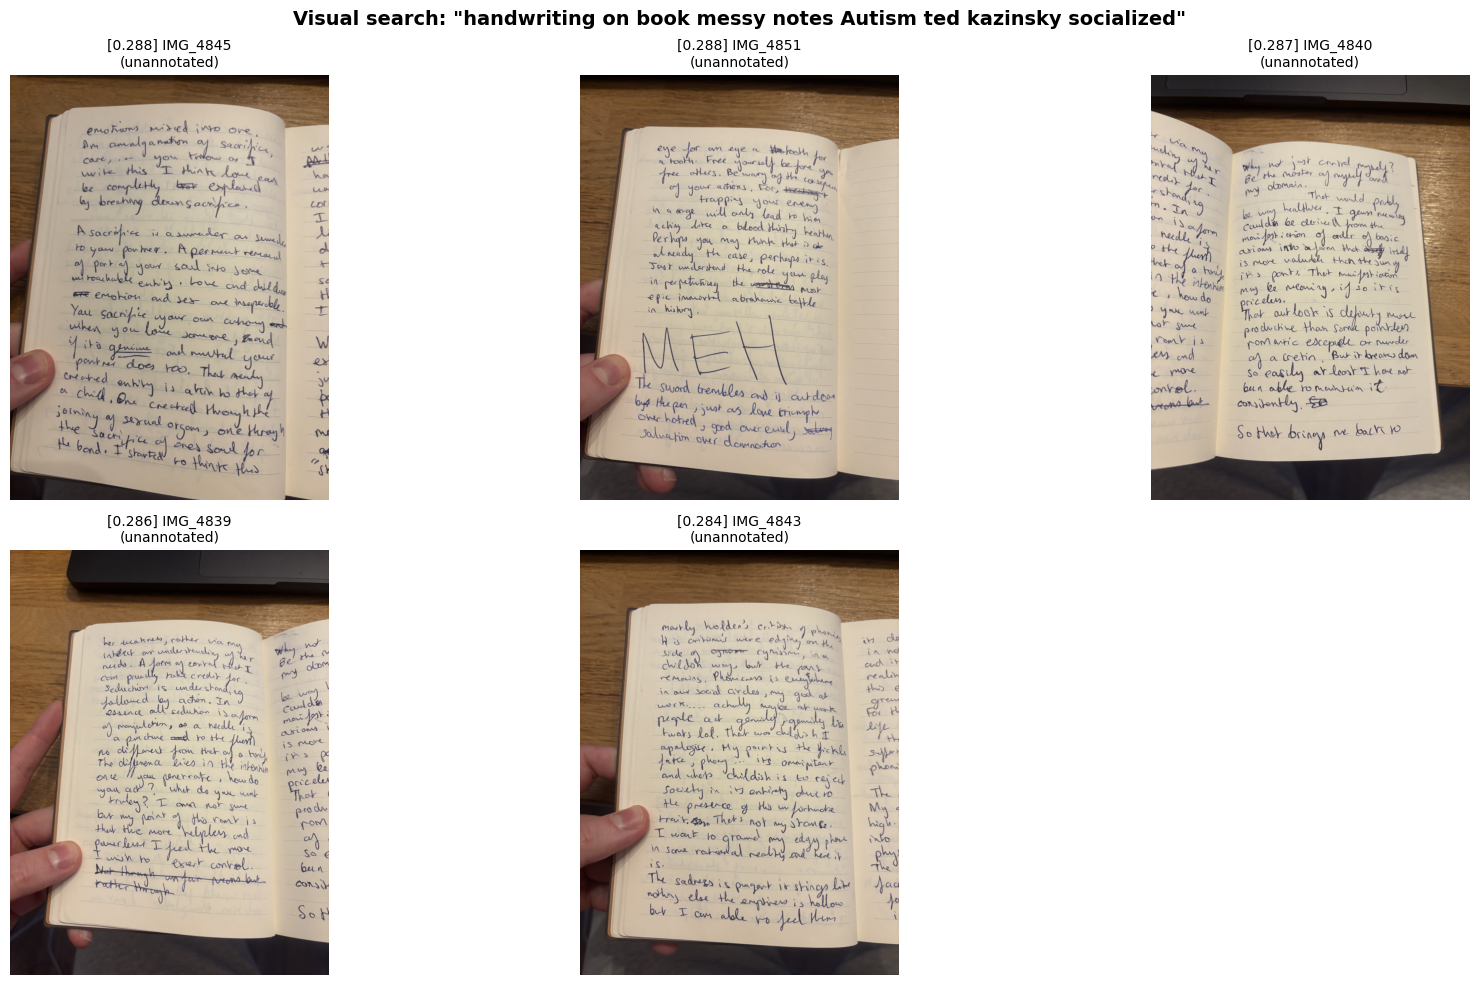

In [25]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from pillow_heif import register_heif_opener
from rag.tools.search_visual import search_visual

register_heif_opener()

INPUT_DIR = Path("../data/input")
IMAGE_EXTENSIONS = (".jpeg", ".jpg", ".png", ".heic", ".heif", ".tiff", ".bmp")


def load_source_image(source_image_id: str) -> Image.Image | None:
    """Load a source image from local cache by its ID."""
    for ext in IMAGE_EXTENSIONS:
        path = INPUT_DIR / f"{source_image_id}{ext}"
        if path.exists():
            return Image.open(path).convert("RGB")
    return None


def display_visual_results(query: str, top_k: int = 5):
    """Search and display matching images in a grid."""
    results = search_visual(query, top_k=top_k)
    if not results:
        print(f"No results for '{query}'")
        return

    cols = min(len(results), 3)
    rows = (len(results) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, r in enumerate(results):
        img = load_source_image(r.source_image_id)
        if img is None:
            axes[idx].text(0.5, 0.5, f"Not found:\n{r.source_image_id}", ha="center", va="center")
        elif r.region_coords:
            x, y, w, h = r.region_coords["x"], r.region_coords["y"], r.region_coords["w"], r.region_coords["h"]
            crop = img.crop((x, y, x + w, y + h))
            axes[idx].imshow(crop)
        else:
            axes[idx].imshow(img)

        label = r.confirmed_text[:30] if r.confirmed_text else "(unannotated)"
        axes[idx].set_title(f"[{r.score:.3f}] {r.source_image_id}\n{label}", fontsize=10)
        axes[idx].axis("off")

    for i in range(len(results), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(f'Visual search: "{query}"', fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


display_visual_results("handwriting on book messy notes Autism ted kazinsky socialized", top_k=5)